# Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import FastICA

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/brux2_data_and_annotations.csv"
data = pd.read_csv(path, sep=',')

time = data[["times"]]
sleepstage = data[["sleepstage"]]
data = data.drop(columns=['times', 'sleepstage'])
columns_names = list(data.columns.values)
data.head()

,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2
0,-2.487790e-06,-0.000007,-0.000008,-0.000007,-0.000008,-0.000007,-5.540293e-06,-5.570818e-06,-6.089744e-06,-2.594628e-07,-7.829670e-06,-0.000003,0.000003,-8.545358e-07,-0.000005,-0.000022,-4.884005e-07,-2.136752e-07
1,-1.083639e-06,-0.000006,-0.000009,-0.000012,-0.000009,-0.000016,-3.434066e-06,-4.197192e-06,-7.280220e-06,-7.493895e-06,-6.761294e-06,-0.000009,-0.000008,-5.798636e-07,-0.000002,-0.000020,-3.052503e-07,-4.273504e-07
2,3.205128e-07,-0.000004,-0.000009,-0.000016,-0.000008,-0.000022,-1.938339e-06,-1.877289e-06,-6.761294e-06,-1.137057e-05,-7.036020e-06,-0.000011,-0.000015,-2.197378e-06,-0.000002,-0.000017,-1.526252e-07,-1.343101e-06
3,4.960317e-06,-0.000001,-0.000006,-0.000015,-0.000006,-0.000019,5.647131e-07,-5.036630e-07,-5.418193e-06,-1.103480e-05,-4.899267e-06,-0.000009,-0.000014,-4.242160e-06,0.000001,-0.000014,5.494505e-07,2.747253e-07
4,5.235043e-06,0.000001,-0.000001,-0.000006,-0.000002,-0.000008,5.341880e-07,4.426129e-07,1.526252e-08,-6.333944e-06,1.068376e-07,-0.000006,-0.000003,-6.836286e-06,-0.000003,-0.000010,-7.936508e-07,-7.020757e-07


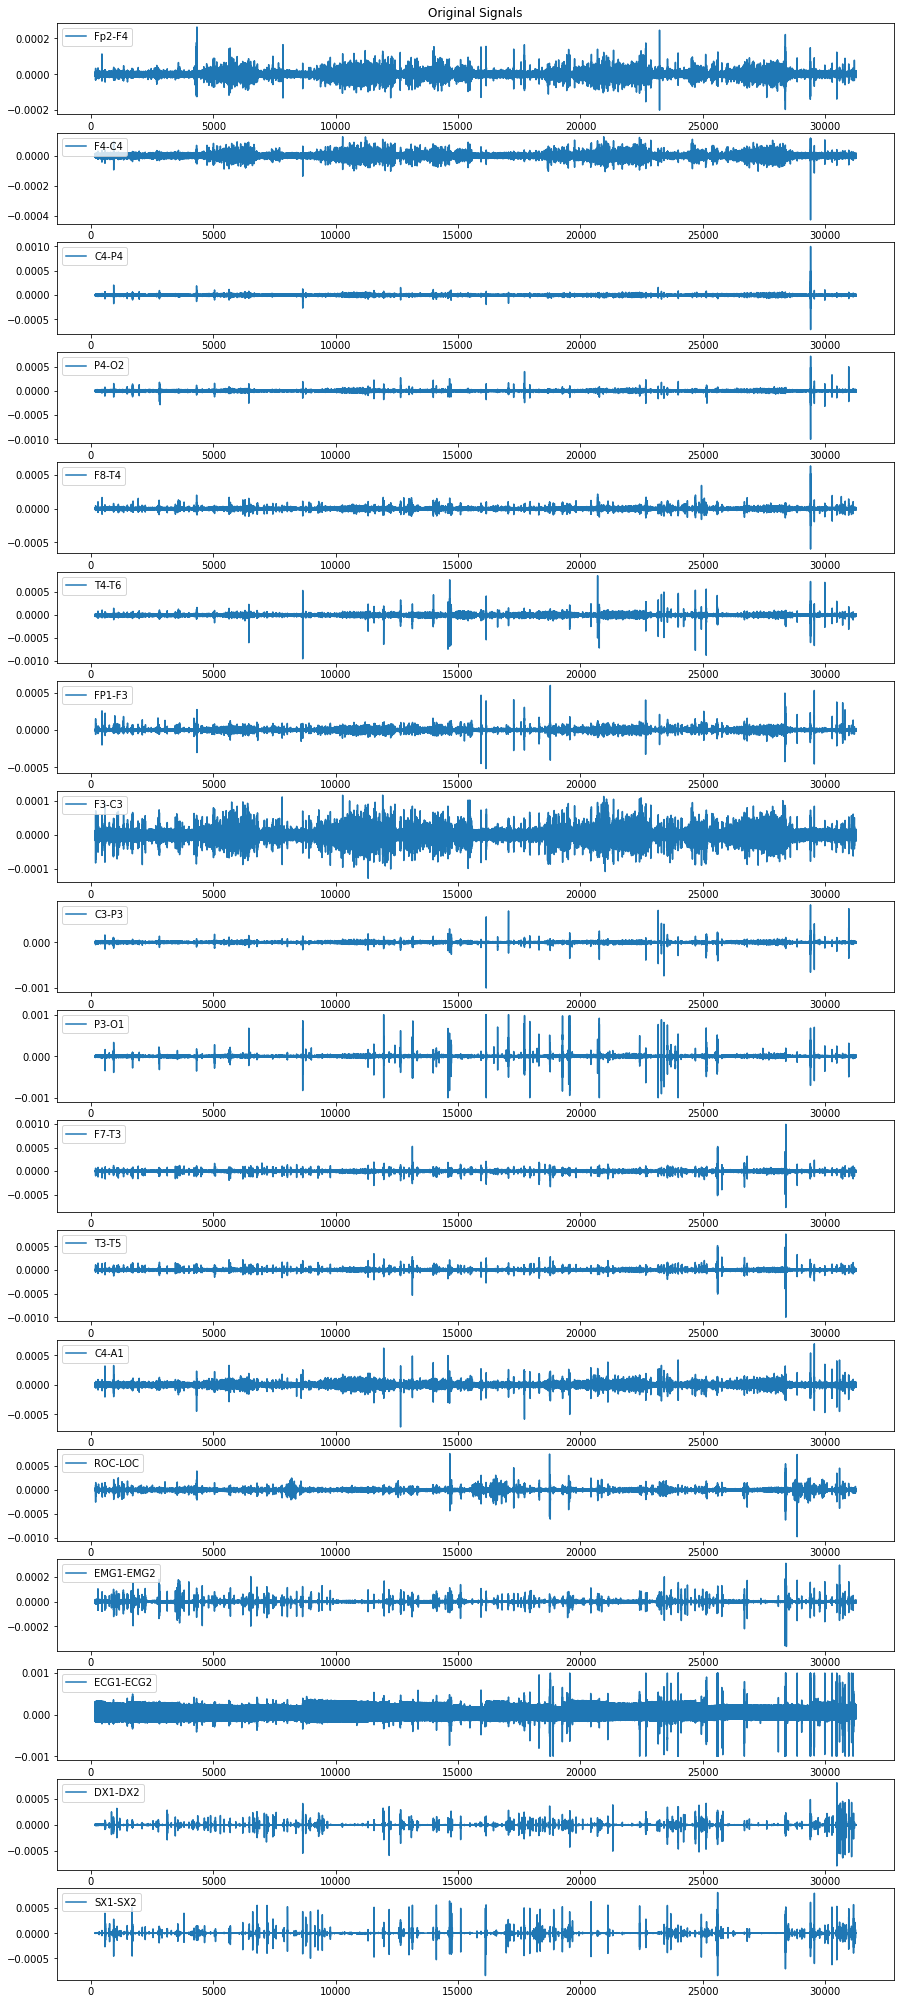

In [ ]:
f, ax = plt.subplots(data.shape[1], 1, figsize=(15, 2*data.shape[1]))
ax[0].set_title("Original Signals")

for i, column_name in enumerate(list(data.columns.values)):
  ax[i].plot(time, data.iloc[:, i], label=column_name)
  ax[i].legend(loc='upper left')

# Preprocessing

## Selection of signals

In [5]:
data = data.drop(columns=['ECG1-ECG2', 'DX1-DX2', 'SX1-SX2', 'EMG1-EMG2', 'ROC-LOC'])
data.head()

n_columns = data.shape[1]
columns_names = list(data.columns.values)
#columns_emg = columns_names[-1]
#columns_eog = columns_names[-2]
#columns_eeg = columns_names[0:n_columns-2]

## Data Standardization 

In [ ]:
sleepstage_parsed = sleepstage['sleepstage'].replace(['W','S1','S2','S3','S4','R'], ['0','1','2','3','3','4'])

sleep_stages_ids = {"W":0, "S1":1, "S2":2, "S3":3, "S4":3, "R":4}
sleepstage_parsed = sleepstage["sleepstage"].apply(lambda x: sleep_stages_ids[x])

data_scaled = MinMaxScaler().fit_transform(data[columns_names])*int(sleepstage_parsed.max())

#data_scaled_eeg = MinMaxScaler().fit_transform(data[columns_eeg])*int(sleepstage_parsed.max())
#data_scaled_eog = MinMaxScaler().fit_transform(data[columns_eog].to_numpy().reshape(-1,1))*int(sleepstage_parsed.max())
#data_scaled_emg = MinMaxScaler().fit_transform(data[columns_emg].to_numpy().reshape(-1,1))*int(sleepstage_parsed.max())

#data_standard_eeg = pd.DataFrame(data_scaled_eeg, columns=columns_eeg)
#data_standard_eog = pd.DataFrame(data_scaled_eog, columns=[columns_eog])
#data_standard_emg = pd.DataFrame(data_scaled_emg, columns=[columns_emg])
#data_standard = pd.concat([data_standard_eeg, data_standard_eog, data_standard_emg], axis=1)

data_standard = pd.DataFrame(data_scaled, columns=columns_names)
data_standard.head()

,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1
0,1.706037,3.038994,1.642053,2.318260,1.919232,2.087788,1.834080,1.994987,2.186469,1.999481,1.731298,2.272839,2.034495
1,1.718165,3.045612,1.639911,2.305651,1.916460,2.069264,1.841617,2.017544,2.183851,1.985016,1.733721,2.258236,2.003929
2,1.730293,3.061056,1.639197,2.296746,1.918638,2.055945,1.846969,2.055639,2.184992,1.977264,1.733098,2.254342,1.984846
3,1.770366,3.080911,1.645337,2.299596,1.925072,2.060881,1.855926,2.078195,2.187946,1.977935,1.737944,2.258375,1.987178
4,1.772739,3.096575,1.657403,2.320326,1.938533,2.086301,1.855816,2.093734,2.199896,1.987335,1.749299,2.265121,2.017140


## Data Visualization

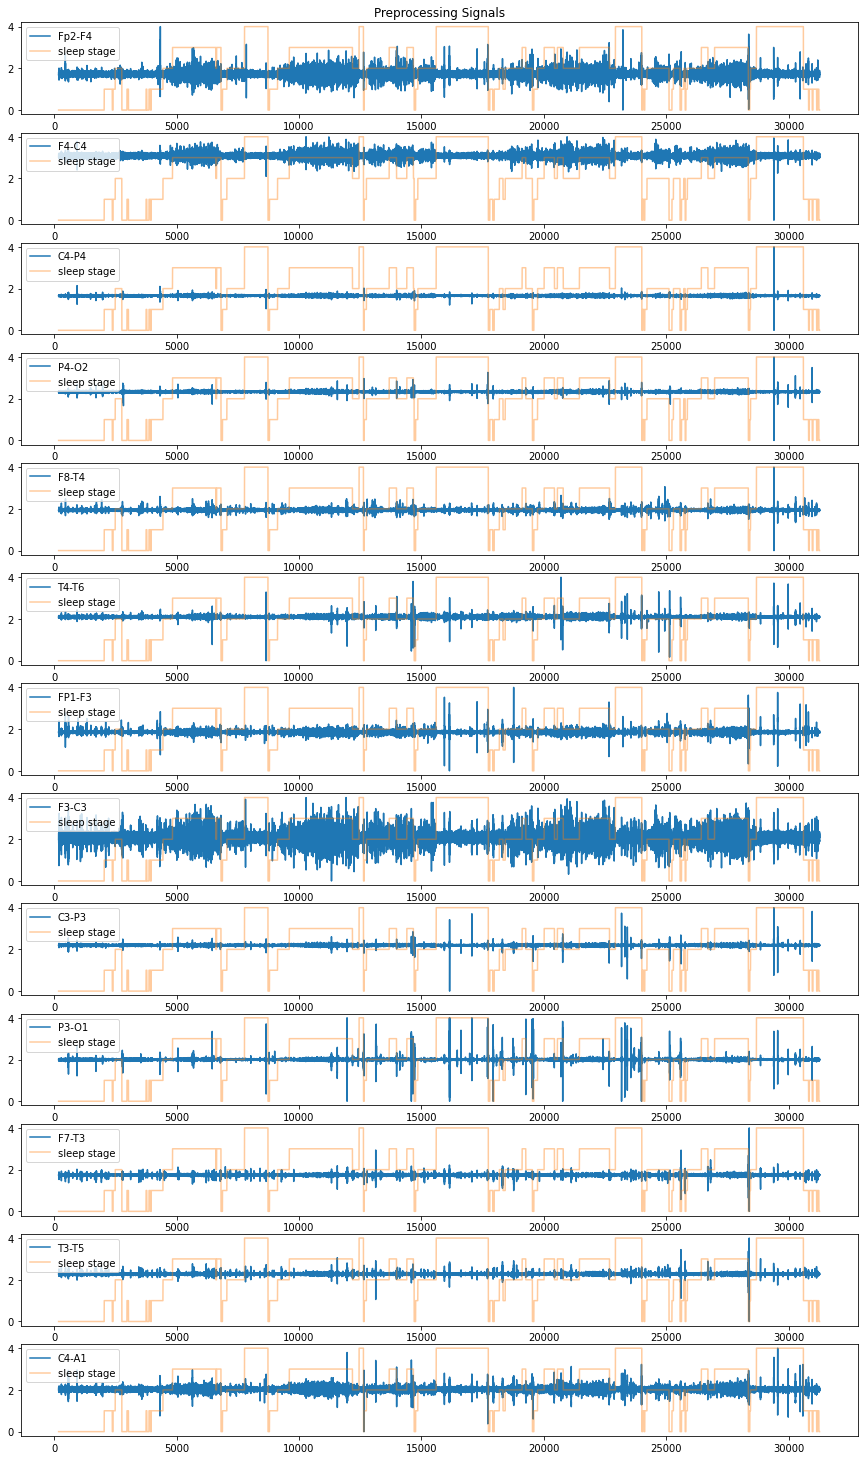

In [ ]:
f, ax = plt.subplots(n_columns, 1, figsize=(15, 2*n_columns))
ax[0].set_title("Preprocessing Signals")

for i, column_name in enumerate(columns_names):
  ax[i].plot(time, data_standard.iloc[:, i], label=column_name)
  ax[i].plot(time, sleepstage_parsed, alpha=0.4, label="sleep stage")
  ax[i].legend(loc='upper left')


# ICA 

## FastICA

In [ ]:
ica_model = FastICA(n_components=n_columns, random_state=0)
S = ica_model.fit_transform(data_standard) 
A = ica_model.mixing_

S_scaled = MinMaxScaler().fit_transform(S)*int(sleepstage_parsed.max())

columns_components =  [f'component#{n}' for n in range(n_columns)]
data_sources = pd.DataFrame(S_scaled, columns=columns_components)
data_sources.head()

,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,component#8,component#9,component#10,component#11,component#12
0,3.032124,2.030474,1.876103,1.954823,2.160418,1.723632,1.605367,1.644392,2.143494,1.722403,2.165848,1.740867,1.277949
1,3.038544,2.021838,1.880663,1.959065,2.177153,1.720639,1.601088,1.647223,2.132468,1.727319,2.169442,1.693937,1.282849
2,3.053332,2.016790,1.882482,1.960310,2.183134,1.715230,1.601441,1.648777,2.124041,1.726405,2.173381,1.662757,1.288539
3,3.068412,2.025742,1.877412,1.963078,2.187408,1.744546,1.601369,1.651170,2.121918,1.727083,2.172988,1.679926,1.275178
4,3.077292,2.028113,1.875909,1.967113,2.190329,1.751100,1.607920,1.649454,2.131817,1.733784,2.172708,1.754581,1.271703


In [ ]:
# Mixing Matrix

print(np.round(A))

[[ 73.  -2.   5.  -1.  10. 135.  16.   4.  -8.   1.   4. -21.  22.]
 [117.   2.   3.   1.  10.   4.   2.   6.  -2.   2.   3.  10.   1.]
 [ 14.  -3.   0.  -0.   8.  -6.  -1.  30.  -2.   1.   1.  23.  -2.]
 [  5.  -4.   0.  -0.  13.  -1.  -5. -34.  -0.   0.  -9.  33.  -4.]
 [ 25. -21.   0.  -1.  -0.   9.  40.  16.   2.   1.   1.  13.   2.]
 [ 13.   2.   1.   4.   7.   3. -11.  -3.  68.  -1.  -5.  28.  -3.]
 [ 24.   8.  61.  -1.   5.  43.   8.   2.  -4.   0.   0.  -6.   8.]
 [204. -26.  -8.  -8.  -3.  45. -21.  18. -16.  -2.  27.  14. 168.]
 [ 12.  -1.  -2.  -1.   1.  -5.   0.   2.  -1.   0.  32.  21.   1.]
 [  4.   0.  -2. -92.  -1.  -1.  -1.  -3.  -1.  -2. -11.  24.  -2.]
 [ 10.  17.   2.   1.  -0.   8.  13.   1.  -1.  44.   2.   4.  12.]
 [ 10.  10.  -0.  -0.  -8.   1.   3.  -1.   1. -44.  -2.  22.   4.]
 [  5. -21.   3.   7. -79. -12. -35.  -3.   6.   7.  -5.  61. -23.]]


### Plotting the results side by side

#### All data

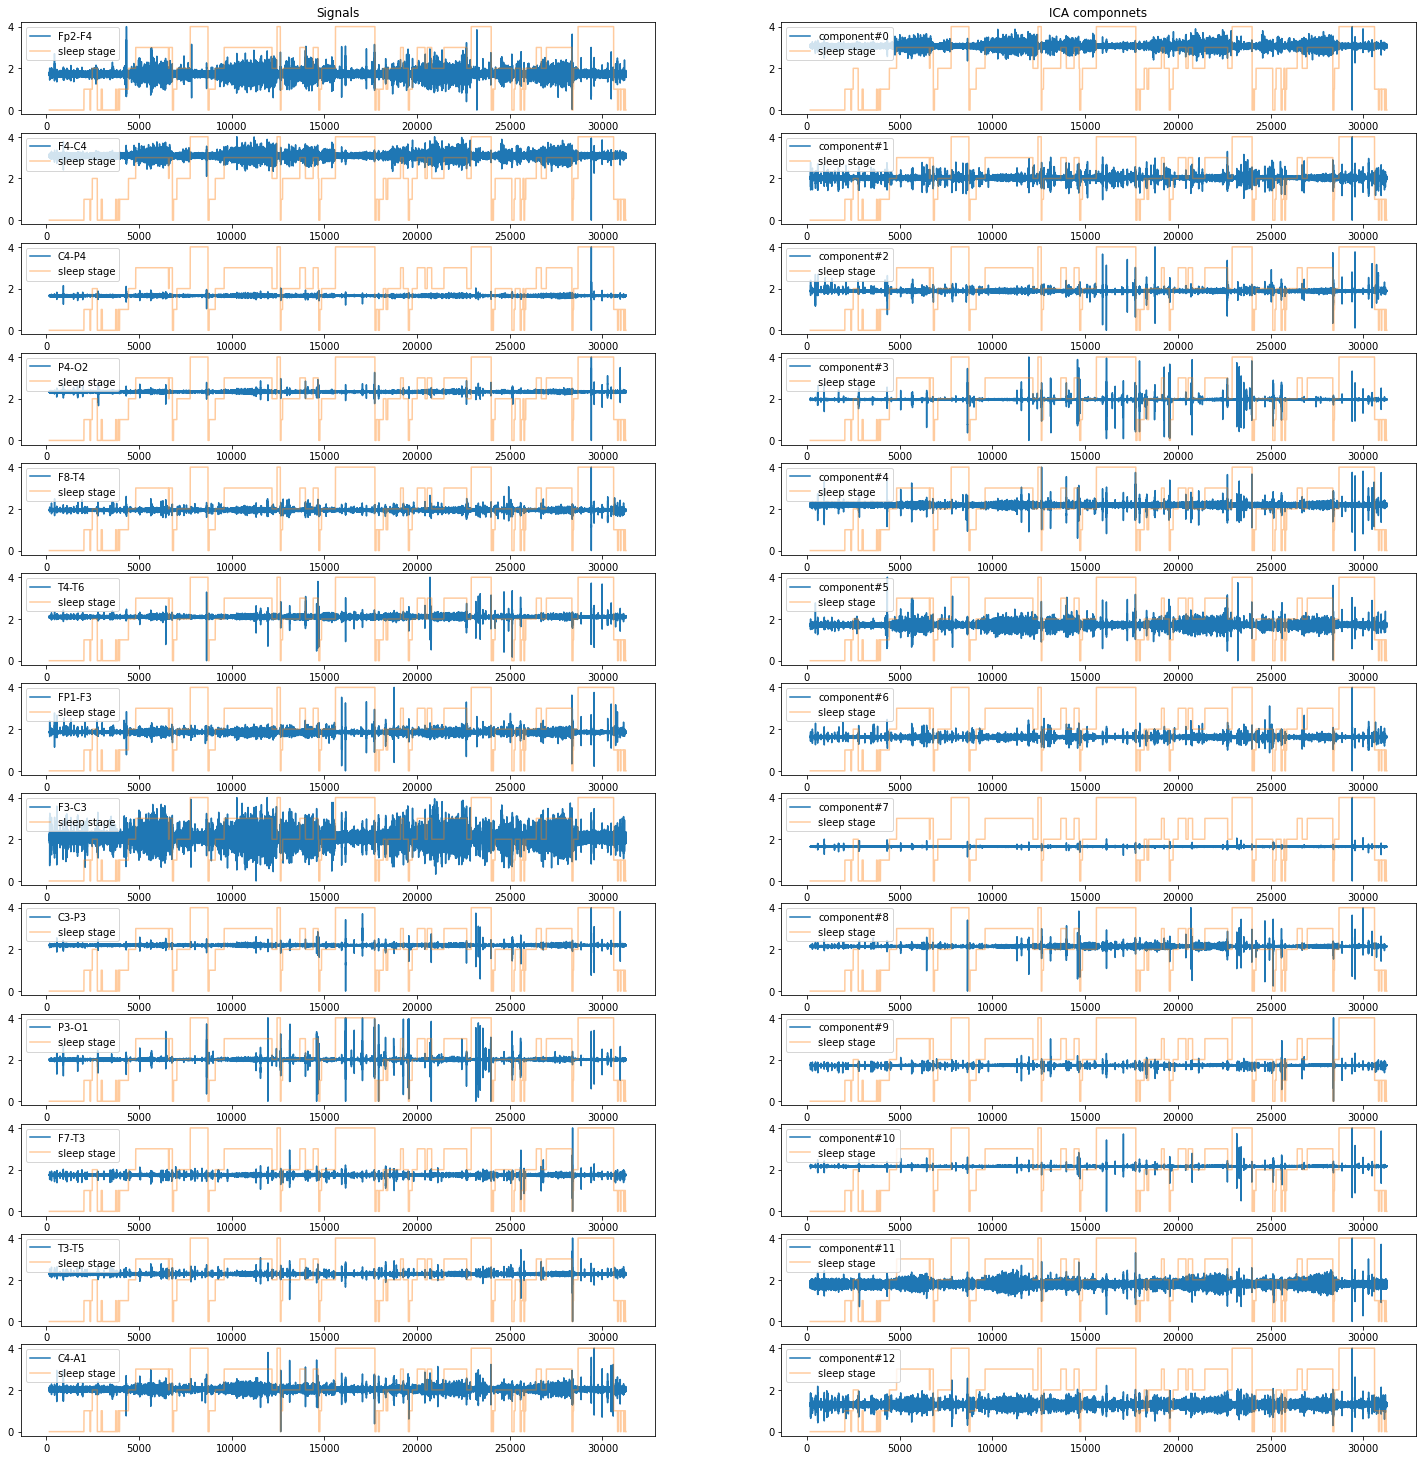

In [ ]:
f, ax = plt.subplots(n_columns, 2, figsize=(25, 2*n_columns))

for j, (signal_type, data_sel, columns) in enumerate([("Signals", data_standard, columns_names),
                                                      ("ICA componnets", data_sources, columns_components)]):
  for i, column_name in enumerate(columns):
    ax[i, j].plot(time, data_sel.iloc[:,i], label=column_name)
    ax[i, j].plot(time, sleepstage_parsed, alpha=0.4, label="sleep stage")
    ax[i, j].legend(loc='upper left')
  
  ax[0,j].set_title(signal_type)
  

#### Smaller portion of the signal

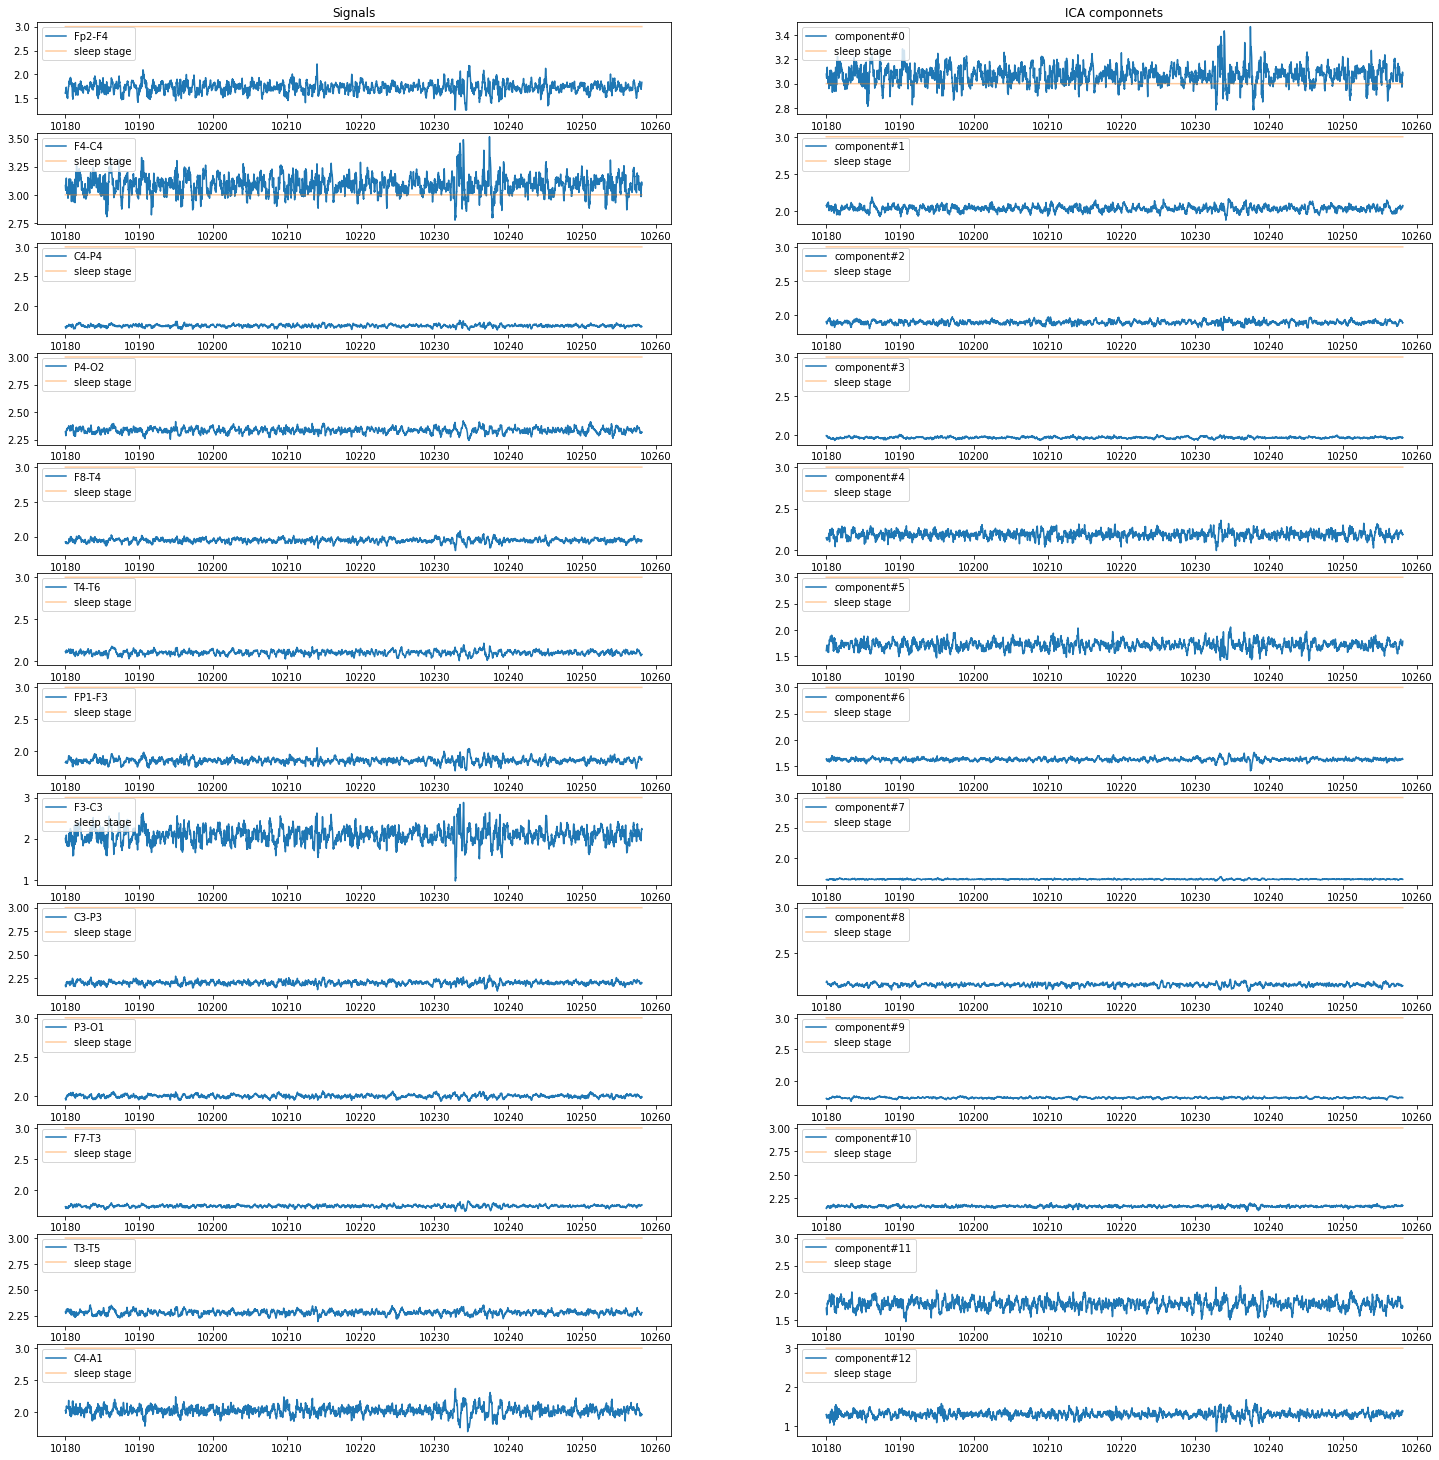

In [ ]:
# 30s ≈ 4000 pontos

dt = time.iloc[1] - time.iloc[0]
ti = int(10000/dt) # o n.º é o ponto visto no gráfico em segundos
tf = ti + 10000 # adicionar mais pontos

f, ax = plt.subplots(n_columns, 2, figsize=(25, 2*n_columns))

for j, (signal_type, data_sel, columns) in enumerate([("Signals", data_standard, columns_names),
                                                    ("ICA componnets", data_sources, columns_components)]):
  for i, column_name in enumerate(columns):
    ax[i, j].plot(time[ti:tf], data_sel.iloc[ti:tf,i], label=column_name)
    ax[i, j].plot(time[ti:tf], sleepstage_parsed[ti:tf], alpha=0.4, label="sleep stage")
    ax[i, j].legend(loc='upper left')
    #ax[i, j].set_ylim(ymin=-0.5, ymax=4.5)
  
  ax[0,j].set_title(signal_type)

## Denoising

In [ ]:
columns_rejected=["component#2","component#3","component#4","component#6", "component#7","component#8","component#9", "component#10"]

data_clean = data_sources.copy()
data_clean[columns_rejected] = 0

data_restored = ica_model.inverse_transform(data_clean)
data_restored_scaled = MinMaxScaler().fit_transform(data_restored)*int(sleepstage_parsed.max())

data_restored_scaled = pd.DataFrame(data_restored_scaled, columns=columns_names)
data_restored_scaled.head()

,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1
0,1.765923,3.033431,1.671041,1.742022,2.186993,1.636787,1.757793,1.957334,1.541206,1.751639,2.068231,1.861874,1.787452
1,1.775819,3.035960,1.622540,1.691356,2.175336,1.580588,1.765756,1.971296,1.486722,1.697859,2.054249,1.799373,1.742335
2,1.785471,3.048959,1.598497,1.659312,2.176460,1.548903,1.774549,2.002015,1.459595,1.664415,2.052335,1.765201,1.712805
3,1.822959,3.068037,1.620809,1.680810,2.202758,1.585917,1.814903,2.021431,1.482419,1.687036,2.078775,1.801905,1.727316
4,1.822189,3.084682,1.712725,1.765590,2.251003,1.685459,1.815309,2.044149,1.583402,1.776044,2.104994,1.907398,1.802721


### Plotting the results side by side

#### All data

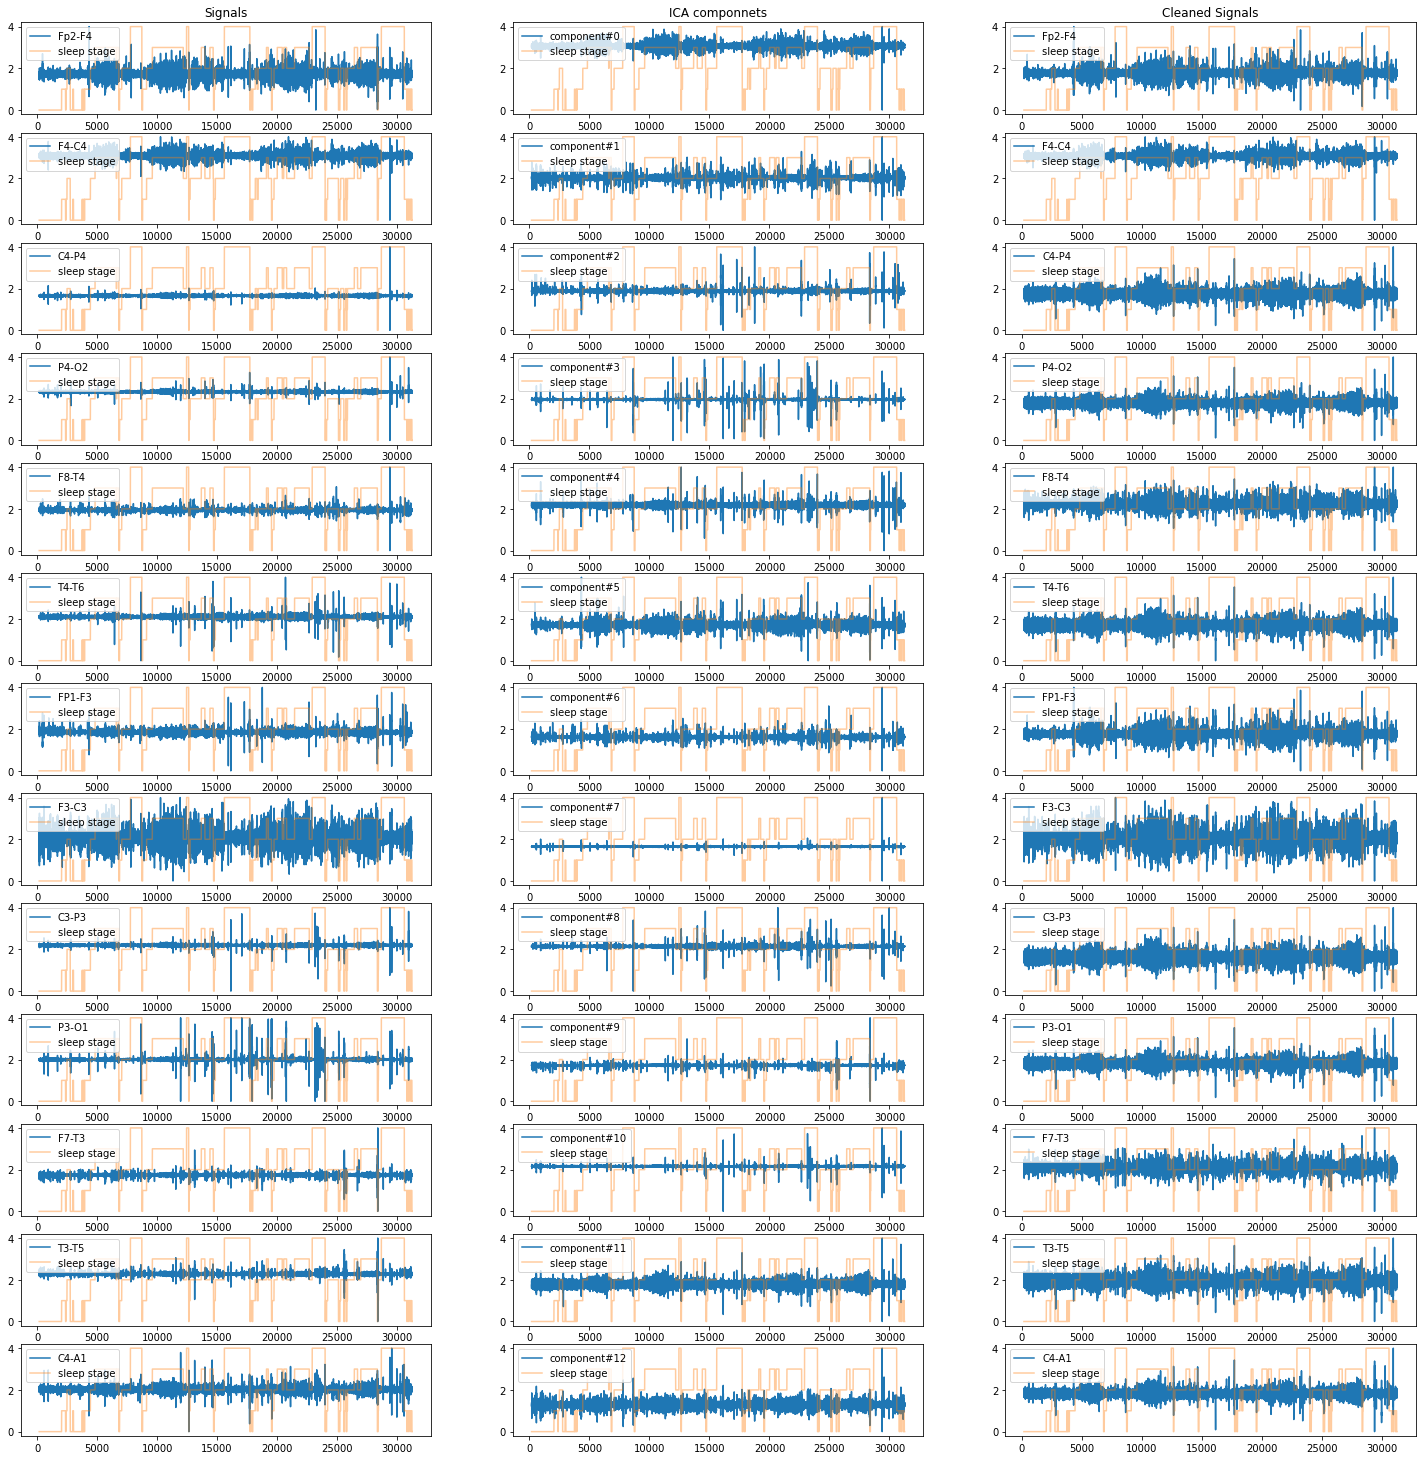

In [ ]:
f, ax = plt.subplots(n_columns, 3, figsize=(25, 2*n_columns))

for j, (signal_type, data_sel, columns) in enumerate([("Signals", data_standard, columns_names),
                                                      ("ICA componnets", data_sources, columns_components),
                                                      ("Cleaned Signals", data_restored_scaled, columns_names)]):
  for i, column_name in enumerate(columns):
    ax[i, j].plot(time, data_sel.iloc[:,i], label=column_name)
    ax[i, j].plot(time, sleepstage_parsed, alpha=0.4, label="sleep stage")   
    ax[i, j].legend(loc='upper left')
  
  ax[0,j].set_title(signal_type)

#### Smaller portion of the signal

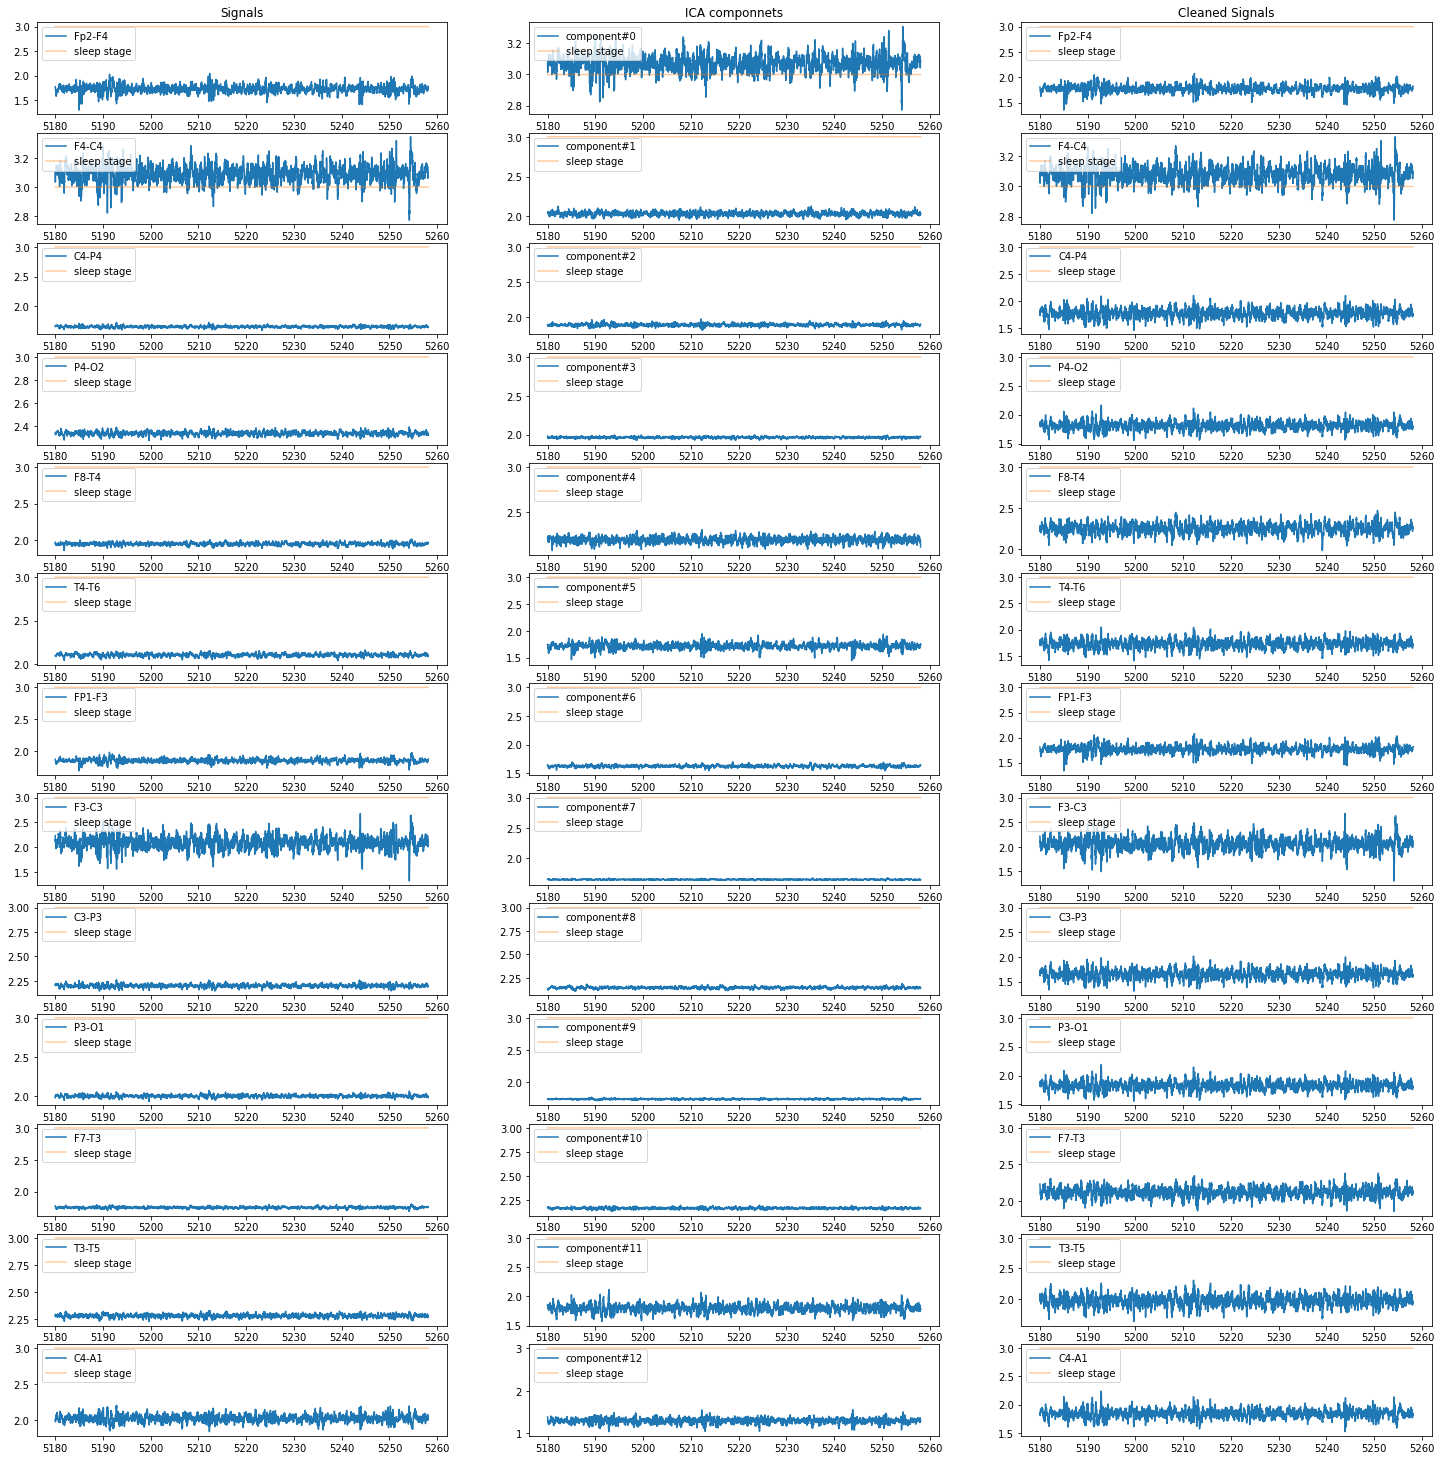

In [ ]:
# 30s ≈ 4000 pontos

dt = time.iloc[1] - time.iloc[0]
ti = int(5000/dt) # o n.º é ponto visto no gráfico em segundos
tf = ti + 10000 # adicionar mais pontos

f, ax = plt.subplots(n_columns, 3, figsize=(25, 2*n_columns))

for j, (signal_type, data_sel, columns) in enumerate([("Signals", data_standard, columns_names),
                                                      ("ICA componnets", data_sources, columns_components),
                                                      ("Cleaned Signals", data_restored_scaled, columns_names)]):
  for i, column_name in enumerate(columns):
    ax[i, j].plot(time[ti:tf], data_sel.iloc[ti:tf,i], label=column_name)
    ax[i, j].plot(time[ti:tf], sleepstage_parsed[ti:tf], alpha=0.4, label="sleep stage")
    ax[i, j].legend(loc='upper left')
  
  ax[0,j].set_title(signal_type)


# Save recovered signals

In [ ]:
data_restored_scaled["times"] = time
data_restored_scaled["sleepstage"] = sleepstage
data_restored_scaled["sleepstage_parsed"] = sleepstage_parsed
data_restored_scaled.head()

path = "/content/gdrive/MyDrive/Universidade/ADAR - Projeto 1/Data/recovered_signals.csv"
data_restored_scaled.to_csv(path, index = False) 